In [15]:
%pip install pandas requests matplotlib

import pandas as pd
import requests
import matplotlib.pyplot as plt
from config import API_KEY


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
# Function to fetch data from Nasdaq API
def fetch_stock_data(symbol, api_key):
    url = f"https://data.nasdaq.com/api/v3/datasets/WIKI/{symbol}.json"
    params = {
        'api_key': api_key
    }
    response = requests.get(url, params=params)
    data = response.json()
    return pd.DataFrame(data['dataset']['data'], columns=data['dataset']['column_names'])

# Fetch data for AT&T, T-Mobile, and Verizon
symbols = {
    'AT&T': 'T',
    'T-Mobile': 'TMUS',
    'Verizon': 'VZ'
}

stock_data = {}
for company, symbol in symbols.items():
    stock_data[company] = fetch_stock_data(symbol, API_KEY)

# Combine the data into a single DataFrame for analysis
combined_data = pd.concat(stock_data.values(), keys=stock_data.keys())
combined_data.reset_index(level=0, inplace=True)
combined_data.rename(columns={'level_0': 'Company'}, inplace=True)

# Save the combined data to a CSV file for further analysis
combined_data.to_csv('combined_data.csv', index=False)

# Display the combined data to verify
combined_data.head()

,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
0,AT&T,2018-03-27,34.85,35.2000,34.69,34.90,33198184.0,0.0,1.0,34.85,35.2000,34.69,34.90,33198184.0
1,AT&T,2018-03-26,35.06,35.2866,34.44,34.69,31281785.0,0.0,1.0,35.06,35.2866,34.44,34.69,31281785.0
2,AT&T,2018-03-23,35.37,35.9900,34.55,34.70,34260415.0,0.0,1.0,35.37,35.9900,34.55,34.70,34260415.0
3,AT&T,2018-03-22,35.95,36.0400,35.36,35.37,28063362.0,0.0,1.0,35.95,36.0400,35.36,35.37,28063362.0
4,AT&T,2018-03-21,36.34,36.5000,36.00,36.00,16776049.0,0.0,1.0,36.34,36.5000,36.00,36.00,16776049.0


In [24]:
# Convert the Date column to datetime format
combined_data['Date'] = pd.to_datetime(combined_data['Date'])

# Sort the data by Company and Date
combined_data.sort_values(by=['Company', 'Date'], inplace=True)

# Handle missing values (if any)
combined_data.fillna(method='ffill', inplace=True)
combined_data.fillna(method='bfill', inplace=True)

# Verify the cleaned data
combined_data.head()


C:\Users\Juanb\AppData\Local\Temp\ipykernel_11508\3598888710.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='ffill', inplace=True)
C:\Users\Juanb\AppData\Local\Temp\ipykernel_11508\3598888710.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_data.fillna(method='bfill', inplace=True)


,Company,Date,Open,High,Low,Close,Volume,Ex-Dividend,Split Ratio,Adj. Open,Adj. High,Adj. Low,Adj. Close,Adj. Volume
8491,AT&T,1984-07-19,59.75,59.87,59.38,59.38,77900.0,0.0,1.0,1.275248,1.277809,1.267351,1.267351,934800.0
8490,AT&T,1984-07-20,59.62,60.00,59.25,59.50,129800.0,0.0,1.0,1.272474,1.280584,1.264577,1.269913,1557600.0
8489,AT&T,1984-07-23,59.25,59.75,58.75,59.50,276100.0,0.0,1.0,1.264577,1.275248,1.253905,1.269913,3313200.0
8488,AT&T,1984-07-24,59.75,60.38,59.62,60.00,129100.0,0.0,1.0,1.275248,1.288694,1.272474,1.280584,1549200.0
8487,AT&T,1984-07-25,60.00,61.37,59.87,60.75,152400.0,0.0,1.0,1.280584,1.309824,1.277809,1.296591,1828800.0


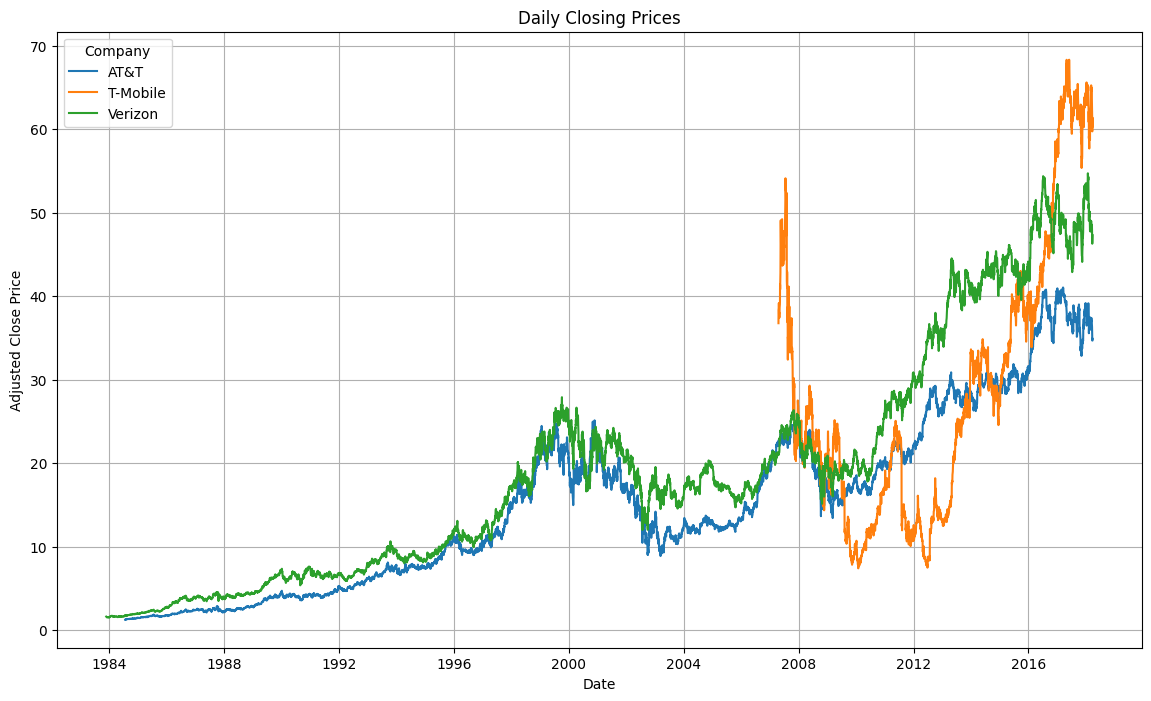

In [25]:
# Plot daily closing prices
plt.figure(figsize=(14, 8))
for company in combined_data['Company'].unique():
    company_data = combined_data[combined_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Adj. Close'], label=company)

plt.title('Daily Closing Prices')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend(title='Company')
plt.grid(True)
plt.show()


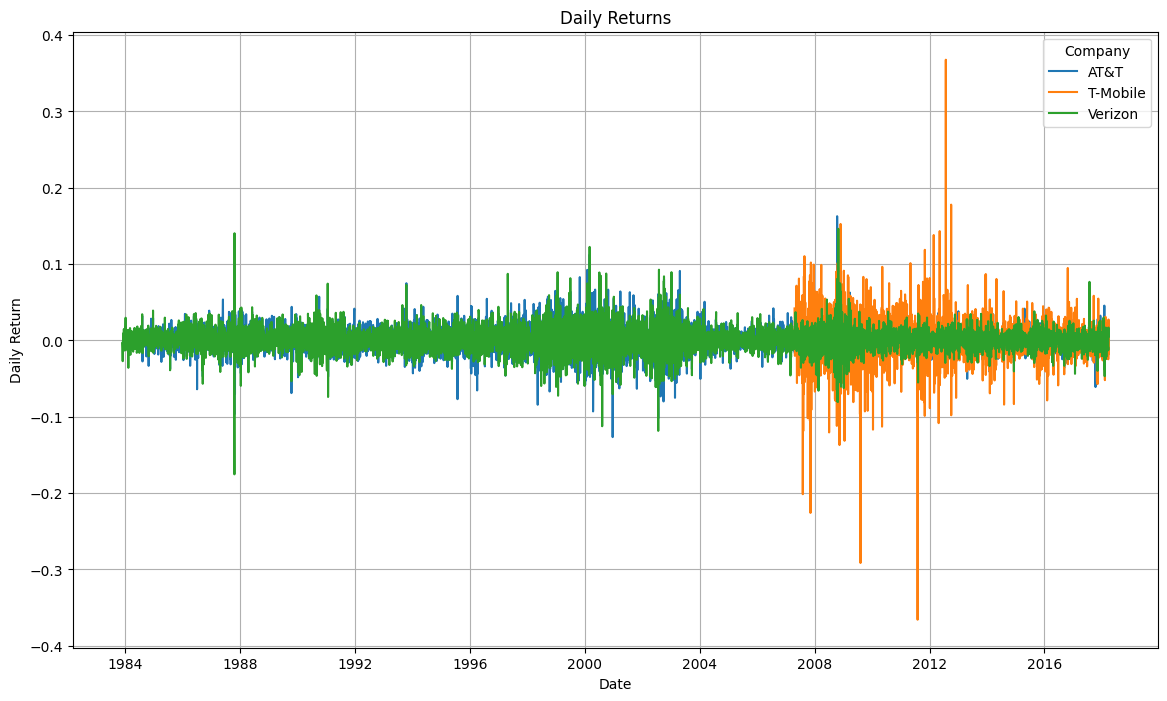

In [26]:
# Calculate daily returns
combined_data['Daily Return'] = combined_data.groupby('Company')['Adj. Close'].pct_change()

# Plot daily returns
plt.figure(figsize=(14, 8))
for company in combined_data['Company'].unique():
    company_data = combined_data[combined_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Daily Return'], label=company)

plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend(title='Company')
plt.grid(True)
plt.show()


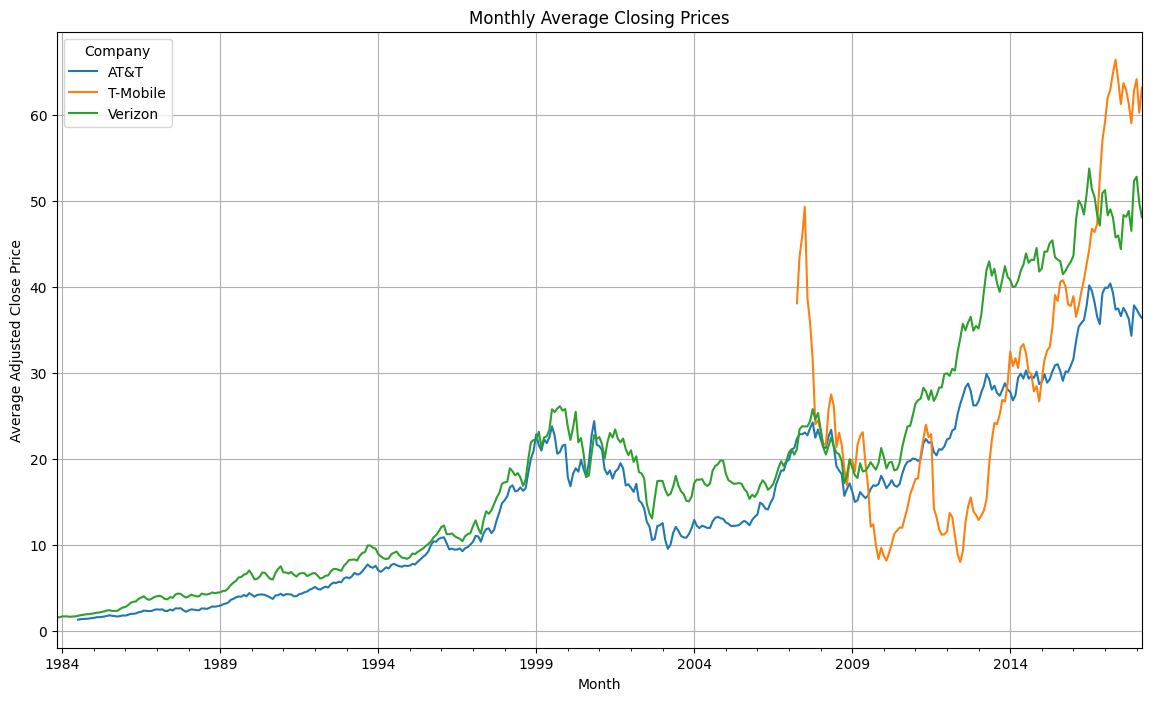

In [27]:
# Calculate monthly average closing prices
combined_data['Month'] = combined_data['Date'].dt.to_period('M')
monthly_avg_close = combined_data.groupby(['Company', 'Month'])['Adj. Close'].mean().unstack(level=0)

# Plot monthly average closing prices
monthly_avg_close.plot(figsize=(14, 8))
plt.title('Monthly Average Closing Prices')
plt.xlabel('Month')
plt.ylabel('Average Adjusted Close Price')
plt.legend(title='Company')
plt.grid(True)
plt.show()


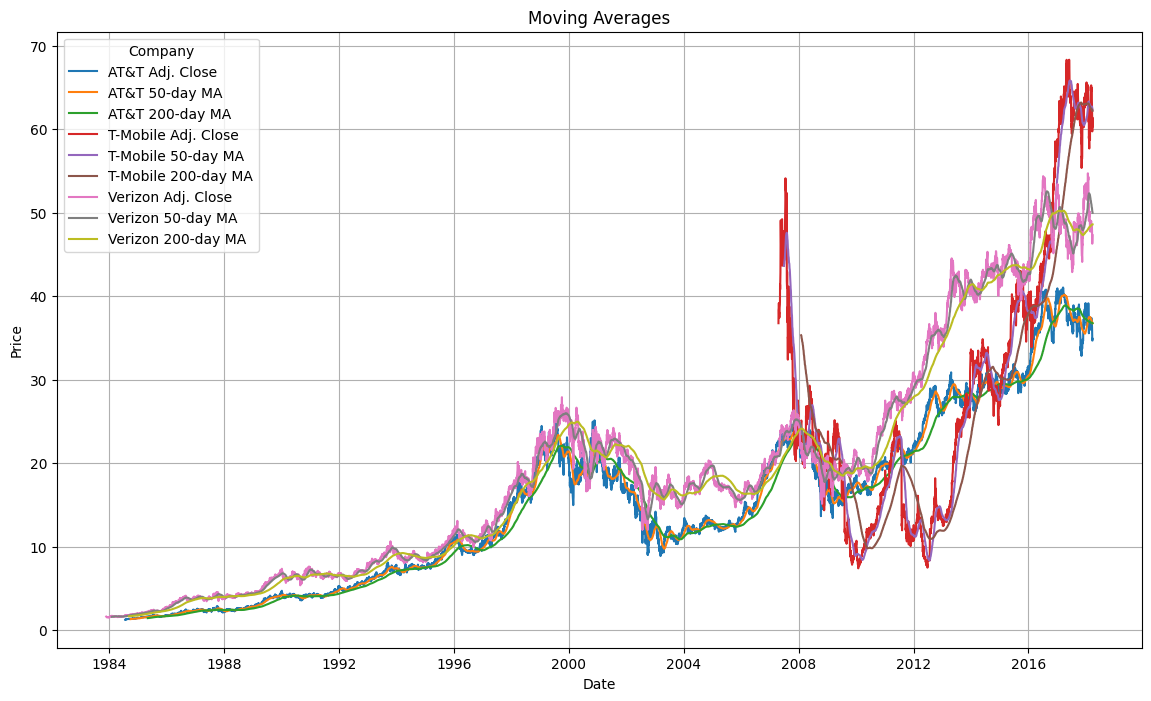

In [28]:
# Calculate 50-day and 200-day moving averages
combined_data['MA50'] = combined_data.groupby('Company')['Adj. Close'].transform(lambda x: x.rolling(window=50).mean())
combined_data['MA200'] = combined_data.groupby('Company')['Adj. Close'].transform(lambda x: x.rolling(window=200).mean())

# Plot moving averages
plt.figure(figsize=(14, 8))
for company in combined_data['Company'].unique():
    company_data = combined_data[combined_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Adj. Close'], label=f'{company} Adj. Close')
    plt.plot(company_data['Date'], company_data['MA50'], label=f'{company} 50-day MA')
    plt.plot(company_data['Date'], company_data['MA200'], label=f'{company} 200-day MA')

plt.title('Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(title='Company')
plt.grid(True)
plt.show()


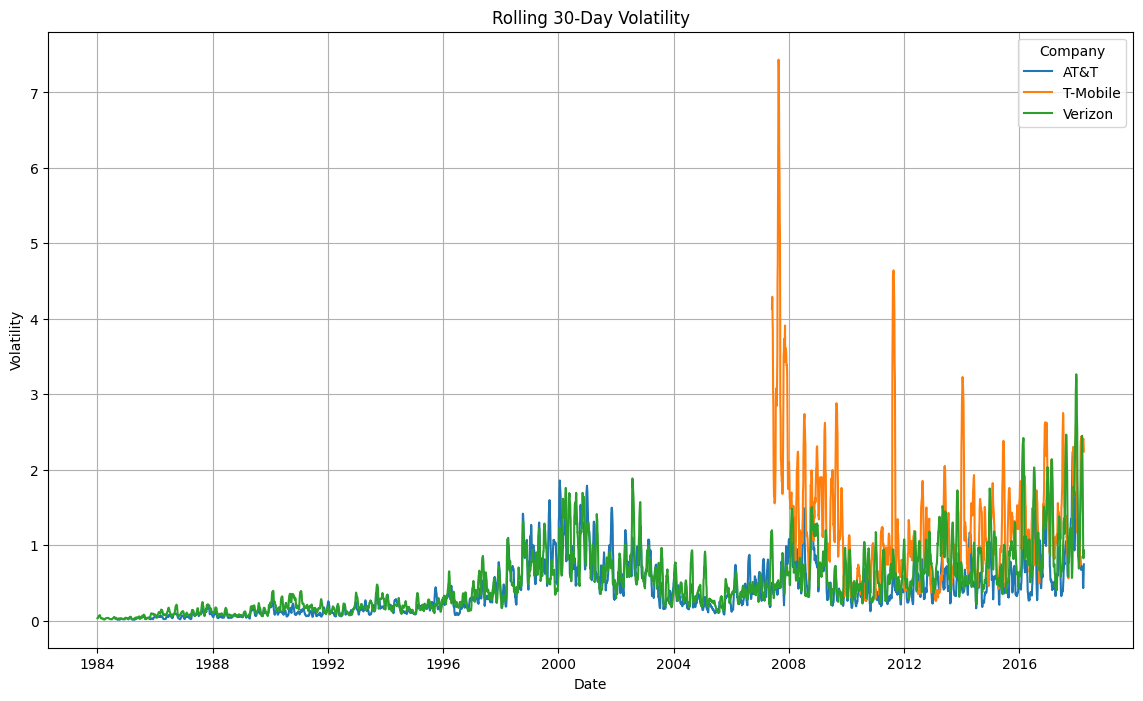

In [29]:
# Calculate rolling 30-day standard deviation (volatility)
combined_data['Rolling Volatility'] = combined_data.groupby('Company')['Adj. Close'].rolling(window=30).std().reset_index(level=0, drop=True)

# Plot rolling volatility
plt.figure(figsize=(14, 8))
for company in combined_data['Company'].unique():
    company_data = combined_data[combined_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Rolling Volatility'], label=company)

plt.title('Rolling 30-Day Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend(title='Company')
plt.grid(True)
plt.show()


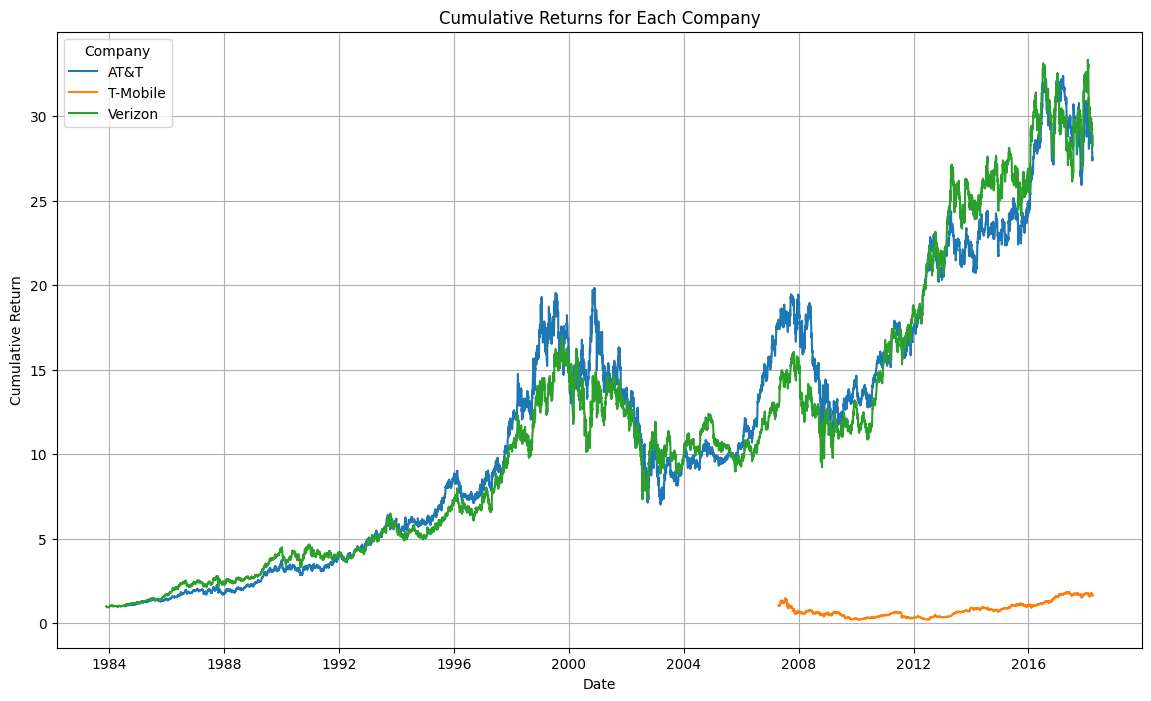

In [35]:
# Ensure proper sorting by date for each company
combined_data.sort_values(by=['Company', 'Date'], inplace=True)

# Calculate daily returns
combined_data['Daily Return'] = combined_data.groupby('Company')['Adj. Close'].pct_change()

# Calculate cumulative returns
combined_data['Cumulative Return'] = (1 + combined_data['Daily Return']).groupby(combined_data['Company']).cumprod()

# Plot cumulative returns
plt.figure(figsize=(14, 8))
for company in combined_data['Company'].unique():
    company_data = combined_data[combined_data['Company'] == company]
    plt.plot(company_data['Date'], company_data['Cumulative Return'], label=company)

plt.title('Cumulative Returns for Each Company')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend(title='Company')
plt.grid(True)
plt.show()